###  <span style="color:red">**This Notebook can be run from Google Colab:**</span>

https://colab.research.google.com

# **<span style="color:red">Background:</span>**

#### First, we trained a model using positive patches only (only patches actually containing regions corresponding to growing bacterial colonies in the petri-dish), to specifically differentiate among the 8 bacterial species in our dataset. From the confusion matrix of that model, we could see that the model is having difficulty to differentiate between classes 'C1' and 'C2-3' and between classes 'C4-7' and 'C5'.<br>

#### As a next step, we then trained a model to specifically learn to differentiate 'C1' vs 'C2-3' vs 'all_other' classes. This is a model with 3 classes only.<br>

#### Similarly, we also trained a model to specifically learn to differentiate 'C4-7' vs 'C5' vs 'all_other' classes.<br>

#### WE also trained a model just to differentiate between positive bacterial colony patches (of any class) and negative patches (either petri-dish background, petri-dish border or white image background). For this, we just combined all positive patches (regardless of the bacterial species) in a single 'positive' class and all negative patches in a single 'negative' class.<br> 

#### We then had 4 models, the first one producing 8 predicted probabilities (one for each baterial species), the second one producing 3 predicted probabilities ('C1','C2-3','all_other'), the third one also producing 3 predicted probabilities ('C4-7','C5','all_other') and the fourth one producing 2 predicted probabilities (positive_patch, negative_patch), for a total of 16 predicted probabilities.<br>

#### With those 4 models, using an augmented validation dataset with 9 classes (8 bacterial species + negative_patches), we combined the 16 predicted probabilities as features and y_true, into a training dataset which we used to use to train a simple kernel SVM, to learn to predict either negative or the correct bacterial species, from the probabilities produced by the 4 models above.

#### **Here we will now evaluate the performance of our combined model on the test set.**

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import os
import zipfile
import shutil
import json
import pickle
from PIL import Image, ImageOps
import time

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

from sklearn.metrics import accuracy_score, confusion_matrix, \
                            classification_report, balanced_accuracy_score

# Import PyDrive and associated libraries (to connect with GoogleDrive):
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# disable warnings
import warnings
warnings.simplefilter("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

### **Check if we are using GPU:**

In [2]:
from keras import backend as K
if K.backend() == "tensorflow":
    import tensorflow as tf
    device_name = tf.test.gpu_device_name()
    if device_name == '':
        device_name = "None"
    print('Using TensorFlow version:', tf.__version__, ', GPU:', device_name)

Using TensorFlow version: 1.15.0 , GPU: /device:GPU:0


### **Download Test Patches from GoogleDrive:**

#### **These are very simple 128x128 test patches with stride=128 (no overlapping), generated just to quickly show how to use the final model function**



In [3]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '17jNLMJvTFOWK-yq3T8k69ufobIpZvO30' # 128X128, stride 128 (no overlap)

downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile(downloaded['title'])
print('Downloaded content: "{}"'.format(downloaded['title']))
print('Root dir content: {}'.format(os.listdir()))
patches_zip = downloaded['title']

Downloaded content: "Patches_test.zip"
Root dir content: ['.config', 'adc.json', 'Patches_test.zip', 'sample_data']


### **Unzip the Test patches:**

In [4]:
# Remove 'Patches' dir if it already exists
if 'Patches_test' in os.listdir():
  shutil.rmtree('./Patches_test')
with zipfile.ZipFile(patches_zip,"r") as zip:
    zip.extractall()
os.remove(downloaded['title'])
print('Root dir content: {}'.format(os.listdir()))

Root dir content: ['.config', 'adc.json', 'Patches_test', 'sample_data']


In [5]:
os.listdir('./Patches_test')

['mixed_colony_images_gt', 'mixed_colony_images_nogt']

In [6]:
for folder in os.listdir('./Patches_test'):
    print(os.listdir('./Patches_test/' + folder))

['Mixed-colony_12', 'Mixed-colony_18', 'Mixed-colony_06', 'Mixed-colony_28', 'Mixed-colony_16', 'Mixed-colony_30', 'Mixed-colony_07', 'Mixed-colony_19', 'Mixed-colony_15', 'Mixed-colony_25', 'Mixed-colony_29', 'Mixed-colony_17', 'Mixed-colony_08', 'Mixed-colony_26', 'Mixed-colony_10', 'Mixed-colony_23', 'Mixed-colony_24', 'Mixed-colony_05', 'Mixed-colony_20', 'Mixed-colony_04', 'Mixed-colony_14', 'Mixed-colony_13', 'Mixed-colony_27', 'Mixed-colony_03', 'Mixed-colony_22', 'Mixed-colony_21', 'Mixed-colony_02', 'Mixed-colony_09', 'Mixed-colony_11', 'Mixed-colony_01']
['Mixed-colony_12', 'Mixed-colony_18', 'Mixed-colony_06', 'Mixed-colony_28', 'Mixed-colony_16', 'Mixed-colony_30', 'Mixed-colony_07', 'Mixed-colony_19', 'Mixed-colony_15', 'Mixed-colony_25', 'Mixed-colony_29', 'Mixed-colony_17', 'Mixed-colony_08', 'Mixed-colony_26', 'Mixed-colony_10', 'Mixed-colony_23', 'Mixed-colony_24', 'Mixed-colony_05', 'Mixed-colony_20', 'Mixed-colony_04', 'Mixed-colony_14', 'Mixed-colony_13', 'Mixed-col

### **Let's count patches by type and petri-dish image:**

In [7]:
patch_dir = './Patches_test/'
img_types = ['mixed_colony_images_nogt', 'mixed_colony_images_gt']

grand_total = 0
for type_ in img_types:
    n_type = 0
    print("\nTotal '{}' Patches per location:".format(type_))
    type_folder = patch_dir + type_ + '/'
    for cls in os.listdir(type_folder):
        cls_folder = type_folder + cls
        n = len(os.listdir(cls_folder))
        n_type += n
        #print(cls_folder, n)
        print('total_{}: {}'.format(cls,n))
    print('Total {}: {}'.format(type_,n_type))
    grand_total += n_type
print('\nGRAND TOTAL: {}'.format(grand_total))


Total 'mixed_colony_images_nogt' Patches per location:
total_Mixed-colony_12: 132
total_Mixed-colony_18: 132
total_Mixed-colony_06: 132
total_Mixed-colony_28: 132
total_Mixed-colony_16: 132
total_Mixed-colony_30: 132
total_Mixed-colony_07: 132
total_Mixed-colony_19: 132
total_Mixed-colony_15: 132
total_Mixed-colony_25: 132
total_Mixed-colony_29: 132
total_Mixed-colony_17: 132
total_Mixed-colony_08: 132
total_Mixed-colony_26: 132
total_Mixed-colony_10: 132
total_Mixed-colony_23: 132
total_Mixed-colony_24: 132
total_Mixed-colony_05: 132
total_Mixed-colony_20: 132
total_Mixed-colony_04: 132
total_Mixed-colony_14: 132
total_Mixed-colony_13: 132
total_Mixed-colony_27: 132
total_Mixed-colony_03: 132
total_Mixed-colony_22: 132
total_Mixed-colony_21: 132
total_Mixed-colony_02: 132
total_Mixed-colony_09: 132
total_Mixed-colony_11: 132
total_Mixed-colony_01: 132
Total mixed_colony_images_nogt: 3960

Total 'mixed_colony_images_gt' Patches per location:
total_Mixed-colony_12: 144
total_Mixed-colo

### **Let's download the 4 final CNN models and the 'combine' from GoogleDrive:**

---



In [8]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

eight_classes_id = '1w0u_EKaSG8zkMRtYkNjFd3IOnR3IpQsJ' # model_8_classes_0.8465
C1_C2_3_id = '18De1DbqyxD1JlNpue6LIUZXd73VgAN-f' # model C1 vs C2-3 vs all_other
C4_7_C5_id = '1-4e6W-yR13q3ckpgo8O9QVMTncWITHwg' # model_C4-7_vs_C5_vs_all-other
pos_vs_neg_id = '1-BxPnguFXE7PHmzKadW0AnwWO9VqTywR' # model pos-neg

files_ids_dict = {'model_eight_classes': eight_classes_id,
                  'model_C1_C2_3': C1_C2_3_id,
                  'model_C4_7_C5': C4_7_C5_id,
                  'model_pos_vs_neg': pos_vs_neg_id}

models_names_dict = {}
for model_name, file_id in files_ids_dict.items():
    downloaded = drive.CreateFile({'id': file_id})
    downloaded.GetContentFile(downloaded['title'])
    print('Downloaded content: "{}"'.format(downloaded['title']))
    models_names_dict[model_name] = downloaded['title']

print('\ncnn_models_names_dict:', str(json.dumps(models_names_dict, indent=2, default=str)))

file_id = '1npIUvxesxWQVMOr8V5enHsTYz-x7-nuE' # 'combine' model_09100
#file_id = '1aw3Bv1vXDlU_9ZTWeMTEzA44Jo3LlIzA' # 'combine' model_09203
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile(downloaded['title'])
print('\nDownloaded content: "{}"'.format(downloaded['title']))
print('\nRoot dir content: {}'.format(os.listdir()))
model_combine = downloaded['title']

Downloaded content: "model_8_classes_08465.h5"
Downloaded content: "model_C1_C2-3_08983.h5"
Downloaded content: "model_C4-7_C5_083.h5"
Downloaded content: "model_pos_neg_09973.h5"

cnn_models_names_dict: {
  "model_eight_classes": "model_8_classes_08465.h5",
  "model_C1_C2_3": "model_C1_C2-3_08983.h5",
  "model_C4_7_C5": "model_C4-7_C5_083.h5",
  "model_pos_vs_neg": "model_pos_neg_09973.h5"
}

Downloaded content: "combine_model_0.9203.sav"

Root dir content: ['.config', 'model_C1_C2-3_08983.h5', 'adc.json', 'model_C4-7_C5_083.h5', 'model_pos_neg_09973.h5', 'Patches_test', 'model_8_classes_08465.h5', 'combine_model_0.9203.sav', 'sample_data']


#### **Let's load all 4 CNN models and the 'combine' model from the files downloaded above:**

In [0]:
eight_classes_model = load_model(models_names_dict['model_eight_classes'])
#eight_classes_model.summary() # summarize model.

In [0]:
C1_C2_3_model = load_model(models_names_dict['model_C1_C2_3'])
#C1_C2_3_model.summary() # summarize model.

In [0]:
C4_7_C5_model = load_model(models_names_dict['model_C4_7_C5'])
#C4_7_C5_model.summary() # summarize model.

In [0]:
pos_vs_neg_model = load_model(models_names_dict['model_pos_vs_neg'])
#pos_vs_neg_C5_model.summary() # summarize model.

In [0]:
combine_model = pickle.load(open(model_combine, 'rb'))

#### **Let's create a function to predict the patch class for an array of patches:**

In [0]:
def predict_patches(X, scaled=False):
    """
    Generates output predictions for the input 128x128 patches.
    :param X: A Numpy array (or array-like) containing the patches.
              X.shape is (N_samples,patch_width,patch_height,channels)
              patch_width,patch_height = 128,128
              channels = 3 (RGB) 
    :param scaled: Boolean. Used to indicate if the patches were already
              scaled from [0-255] to [0-1].          
    :return: predictions, class_dict
             predictions: array of shape (N_samples,) with the class indices
             classs_dict: class dictionary mapping indices to class_names
    """ 
    if not scaled: X = X.astype('float64')/255
    eight_classes_scores = eight_classes_model.predict(X)
    C1_C2_3_scores = C1_C2_3_model.predict(X)
    C4_7_C5_scores = C4_7_C5_model.predict(X)
    pos_vs_neg_scores = pos_vs_neg_model.predict(X)

    X_probs = np.hstack((eight_classes_scores,C1_C2_3_scores,C4_7_C5_scores,pos_vs_neg_scores))
    y_pred = combine_model.predict(X_probs)
    y_pos_neg = np.argmax(pos_vs_neg_scores, axis=1)
    y_pred[y_pos_neg==0] = 8
    class_dict = {0: "C10_pos",
                  1 :"C1_pos",
                  2: "C2-3_pos",
                  3: "C4-7_pos",
                  4: "C5_pos",
                  5: "C6_pos",
                  6: "C8_pos",
                  7: "C9_pos",
                  8: "neg"}
    return y_pred, class_dict

#### **Let's create an array X with all the patches for all images in 'mixed_colony_images_nogt':**

In [40]:
type_ = 'mixed_colony_images_nogt'
type_folder = patch_dir + type_ + '/'
colonies = os.listdir(type_folder)

X=[]
patches = []

for cls in colonies:
    cls_folder = type_folder + cls + '/'
    patch_names = os.listdir(cls_folder)
    cls_patches = [cls_folder+file for file in patch_names]
    for patch in cls_patches:
        img = mpimg.imread(patch)
        X.append(img)
    patches+= cls_patches
X = np.array(X)
print ('X.shape:', X.shape)
print('total patches:', len(patches))

X.shape: (3960, 128, 128, 3)
total patches: 3960


#### **Let's use the function above to make predicions on the patches for the randomly selected test image:**

In [130]:
start_time = time.time()
y_pred, class_dict = predict_patches(X, scaled=False)
print("--- %s seconds ---" % (time.time() - start_time))

--- 11.0433988571167 seconds ---


#### **Yup, that's it, we have the predictions!**

#### **Let's create a dictionary to map images to patches corresponding to each image, to predicted class corresponding to each patch:**

In [0]:
predictions_dict = {colony:{} for colony in colonies}

for i, pred in enumerate(list(y_pred)):
    for k in predictions_dict.keys():
        if k in patches[i]:
            predictions_dict[k][patches[i]] = class_dict[pred]

### **Let's visualize the first 5 images in the dictionary that we created above:**



Results for Mixed-colony_12:


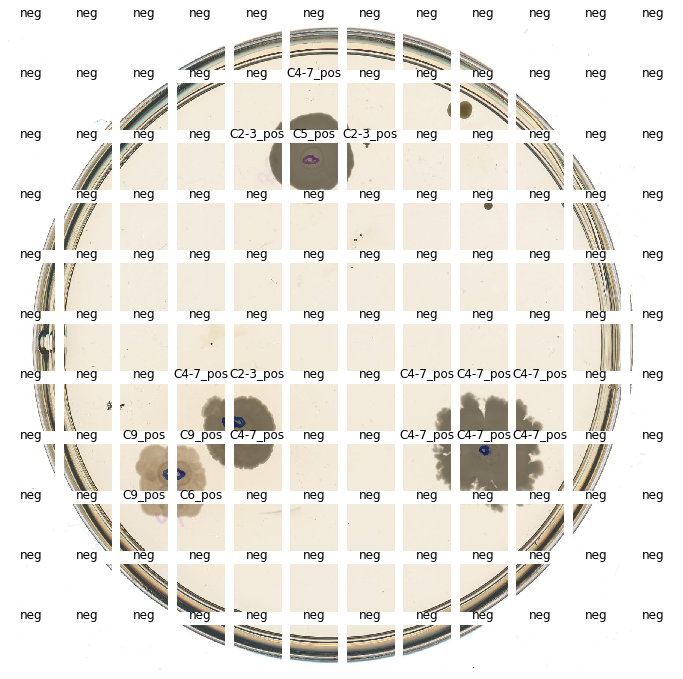



Results for Mixed-colony_18:


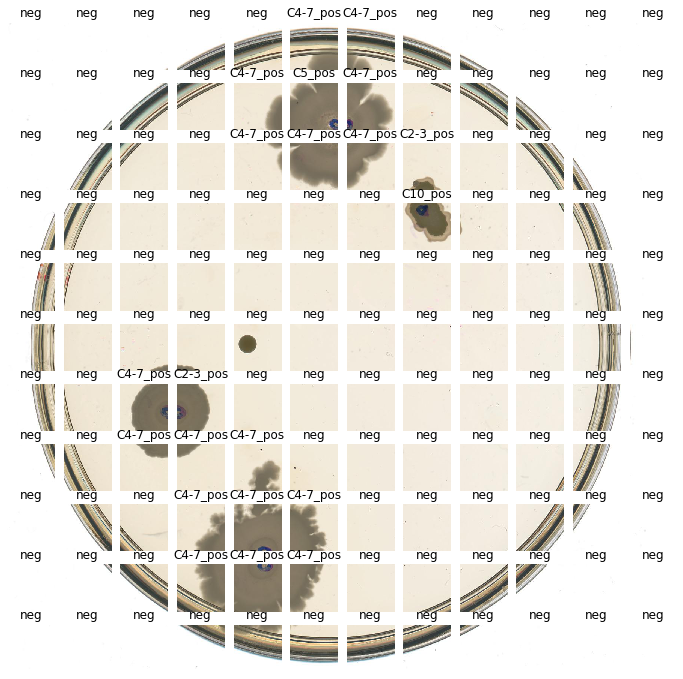



Results for Mixed-colony_06:


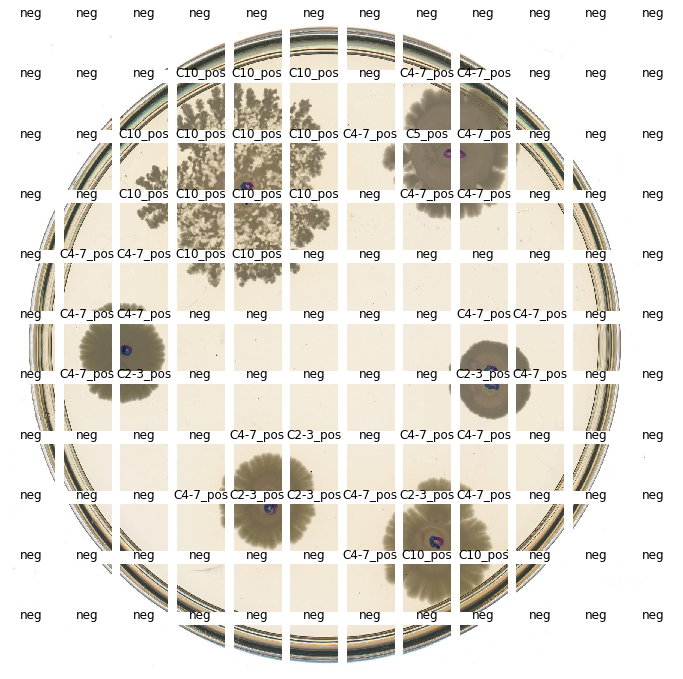



Results for Mixed-colony_28:


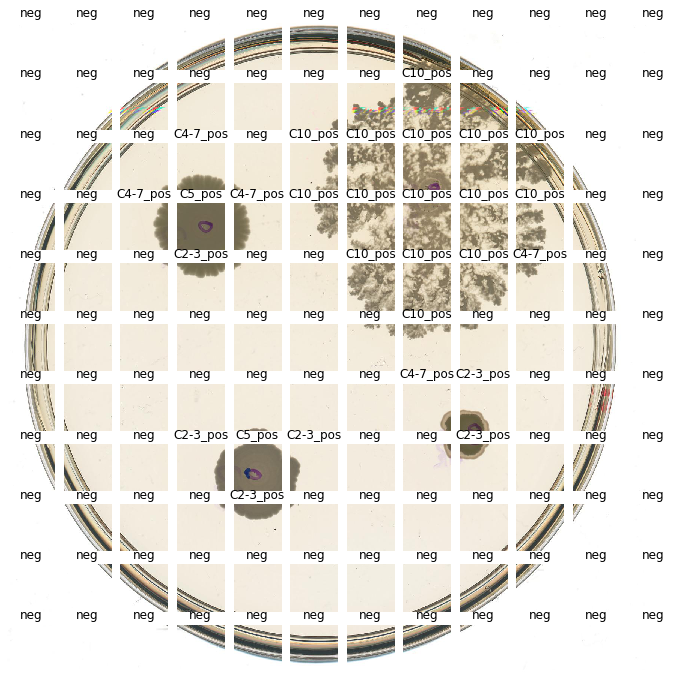



Results for Mixed-colony_16:


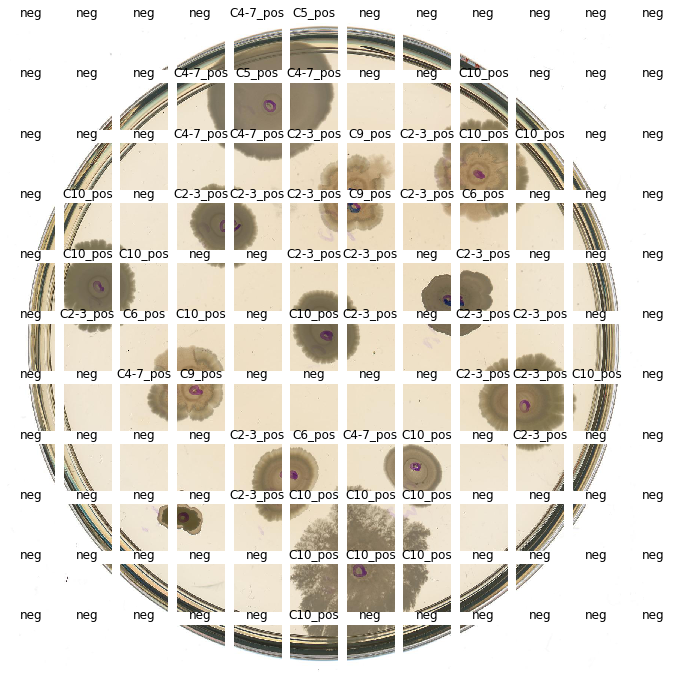

In [137]:
fig_height = 11 # len(range(0,imgheight,stride[1]))
fig_width = 12 #len(range(0,imgwidth,stride[0]))

counter = 0
for colony, colony_pred_dict in predictions_dict.items():
    print('\n\nResults for {}:'.format(colony))
    counter += 1
    sorted_patches = []
    sorted_preds = []
    for j in range(fig_height):
        for k in range(fig_width):
            for patch, pred in colony_pred_dict.items():
                if '_{}_{}_'.format(j,k) in patch:
                    sorted_patches.append(patch)
                    sorted_preds.append(pred) 

    i = 0
    fig, axes1 = plt.subplots(fig_height,fig_width,figsize=(12,12))
    for j in range(fig_height):
        for k in range(fig_width):
            axes1[j][k].set_axis_off()
            patch = Image.open(sorted_patches[i])
            axes1[j][k].imshow(np.asarray(patch))
            axes1[j][k].set_title(sorted_preds[i])
            i += 1
    plt.show()
    if counter >= 5: break

# **Next Steps:**



#### **Use the final model function to generate heatmaps.**

#### **I would recommend to overlap the 128x128 patches (e.g. stride = 10) so we will have several predictions for the same pixels region which will allows to make a combined prediction.**